In [1]:
import torch
from torch.utils.data import DataLoader
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
from model import *
from dataset import *
from utils import *
from train import *

# Check if GPU is available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
device

'cuda'

In [2]:
train_story_list = dict(
    Moth1=["souls", "avatar", "legacy", "odetostepfather"],
    Moth2=["howtodraw", "myfirstdaywiththeyankees", "naked", "life"],
    Moth3=["tildeath", "fromboyhoodtofatherhood", "sloth", "exorcism"],
    Moth4=["adollshouse", "inamoment", "theclosetthatateeverything", "adventuresinsayingyes", "haveyoumethimyet"],
    Moth5=["thatthingonmyarm", "eyespy", "itsabox", "hangtime"],
)
train_stories = [story for session in train_story_list.keys() for story in train_story_list[session]]
val_stories = [["swimmingwithastronauts1", "swimmingwithastronauts2"]]
test_stories = [["alternateithicatom1", "alternateithicatom2"], ["undertheinfluence1", "undertheinfluence2"], ["stagefright1", "stagefright2"], ["buck1", "buck2"]]

In [7]:
# config
name = "WdPnFq-seg8-flexconv4-A"
which = "val-loss-min"
SAVEFIG = False

with open(f"config/{name}.yaml", "r") as f:
    config = yaml.safe_load(f)
MEG_SUBJECT = config["MEG_SUBJECT"]
FMRI_SUBJECT = config["FMRI_SUBJECT"]
use_segment = config["use_segment"]
spacing = config["spacing"]
meg_loss_weight = config["meg_loss_weight"]
fmri_loss_weight = config["fmri_loss_weight"]
softmax_T = config["softmax_T"]
dataset_params = config["dataset"]
model_params = config["model"]

## Dataset

In [9]:
train_dataset = StoryDataset(
    MEG_SUBJECT,
    FMRI_SUBJECT,
    train_stories[0:1],
    name=name,
    spacing=spacing,
    preload=False,
    **dataset_params,
)  # evalulate don't care this
val_dataset = StoryDataset(
    MEG_SUBJECT,
    FMRI_SUBJECT,
    val_stories,
    name=name,
    spacing=spacing,
    pca_meg=train_dataset.pca_meg,
    pca_mri=train_dataset.pca_mri,
    **dataset_params,
)
test_dataset = StoryDataset(
    MEG_SUBJECT,
    FMRI_SUBJECT,
    test_stories,
    name=name,
    spacing=spacing,
    pca_meg=train_dataset.pca_meg,
    pca_mri=train_dataset.pca_mri,
    MEG_DIR="moth_meg",
    **dataset_params,
)
embed_dim = test_dataset.embed_dim

use_word: True, use_phoneme: True, use_freq: True, use_meg: False, use_mri: False
embed_dim:  852
use_word: True, use_phoneme: True, use_freq: True, use_meg: False, use_mri: False
embed_dim:  852
Loading story swimmingwithastronauts1...
Finished loading story swimmingwithastronauts1!
Loading story swimmingwithastronauts2...


Finished loading story swimmingwithastronauts2!
Preloaded all stories!
use_word: True, use_phoneme: True, use_freq: True, use_meg: False, use_mri: False
embed_dim:  852
Loading story alternateithicatom1...
Finished loading story alternateithicatom1!
Loading story alternateithicatom2...
Finished loading story alternateithicatom2!
Loading story undertheinfluence1...
Finished loading story undertheinfluence1!
Loading story undertheinfluence2...
Finished loading story undertheinfluence2!
Loading story stagefright1...
Finished loading story stagefright1!
Loading story stagefright2...
Finished loading story stagefright2!
Loading story buck1...
Finished loading story buck1!
Loading story buck2...
Finished loading story buck2!
Preloaded all stories!


## Lead Field

In [10]:
# load forward solution to get the lead field
fname_fwd = f"data/{MEG_SUBJECT}-{spacing}-fwd.fif"
fwd = mne.read_forward_solution(fname_fwd)
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True, use_cps=True)  # let's do fixed orientation
lead_field = fwd_fixed["sol"]["data"]
lead_field = torch.from_numpy(lead_field)
n_channels, n_neurons = lead_field.shape
n_channels, n_neurons

Reading forward solution from /home/yishuli/MEG-fMRI/data/A-oct6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]


(306, 8196)

## Evalulate

In [11]:
model = TransformerSourceModel(
    embed_dim=embed_dim,
    lead_field=lead_field,
    **model_params,
).to(device)
ckpt_path = f"trained_models/{name}_{which}.pth"
info = load_checkpoint(ckpt_path, model, None, None, device=device)
print(info)

(68, 1.0055146501442056, 0.07546357089945342, 0.9299632706765684)


In [12]:
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
with torch.no_grad():
    validate(
        model,
        val_dataloader,
        device,
        subject=MEG_SUBJECT,
        meg_loss_weight=meg_loss_weight,
        fmri_loss_weight=fmri_loss_weight,
        softmax_T=softmax_T,
    )

val_meg_loss: 0.07466866387896606, val_fmri_loss: 0.9308459862652395


In [13]:
model.eval()
corr_meg, corr_fmri = [], []
for i in range(len(test_dataset)):
    # load data
    embeds, meg, fmri = test_dataset[i]
    embeds = embeds.to(device)
    # foward pass
    with torch.no_grad():
        _, meg_pred, fmri_pred = model(embeds.unsqueeze(0))
    meg_pred = meg_pred.detach().cpu().squeeze(0)
    fmri_pred = fmri_pred.detach().cpu().squeeze(0)
    # calculate corr
    _corr_meg = corr_multi_torch(meg, meg_pred)
    _corr_fmri = corr_multi_torch(fmri, fmri_pred)
    corr_meg.append(_corr_meg.cpu().numpy())
    corr_fmri.append(_corr_fmri.cpu().numpy())
    # save memory
    del embeds, meg_pred, fmri_pred
    torch.cuda.empty_cache()
corr_meg = np.mean(corr_meg, axis=0)
corr_fmri = np.mean(corr_fmri, axis=0)

In [14]:
corr_meg.shape, corr_fmri.shape

((306,), (8196,))

## Plot

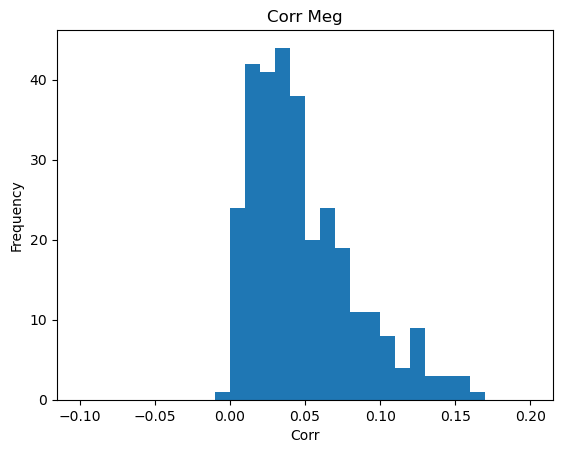

In [15]:
plt.hist(corr_meg, bins=np.arange(-0.1, 0.2, 0.01))
plt.title("Corr Meg")
plt.xlabel("Corr")
plt.ylabel("Frequency")
plt.show()

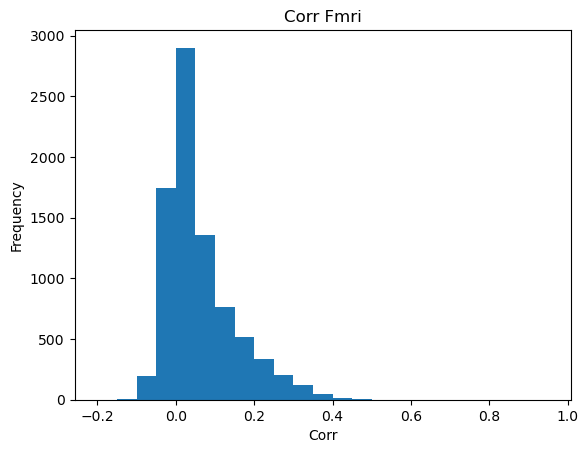

In [16]:
plt.hist(corr_fmri, bins=np.arange(-0.2, 1, 0.05))
plt.title("Corr Fmri")
plt.xlabel("Corr")
plt.ylabel("Frequency")
plt.show()

In [17]:
raw_path = test_dataset.file_path_dict["meg"][test_dataset.all_stories_flatten[0]]
raw = mne.io.read_raw_fif(raw_path).load_data()

mag_idx = mne.channel_indices_by_type(raw.copy().info, "meg")["mag"]
grad_idx = mne.channel_indices_by_type(raw.copy().info, "meg")["grad"]
mag_info = raw.copy().pick("mag").info
grad_info = raw.copy().pick("grad").info

Opening raw data file /data/story_dataset/moth_meg/Moth1/sss-S_band-1-150_notch-60-120_ecg-ica_eog-ica_audio-corrected/A/aligned_ds50/A_Moth1_02_sss-S_band-1-150_notch-60-120_ecg-ica_eog-ica_audio-corrected_aligned_ds50_raw.fif...
    Range : 2088 ... 37554 =     41.760 ...   751.080 secs
Ready.
Reading 0 ... 35466  =      0.000 ...   709.320 secs...


In [18]:
# get mag and grad indices and infos
mag_idx = mne.channel_indices_by_type(raw.copy().info, "meg")["mag"]
grad_idx = mne.channel_indices_by_type(raw.copy().info, "meg")["grad"]
mag_info = raw.copy().pick("mag").info
grad_info = raw.copy().pick("grad").info

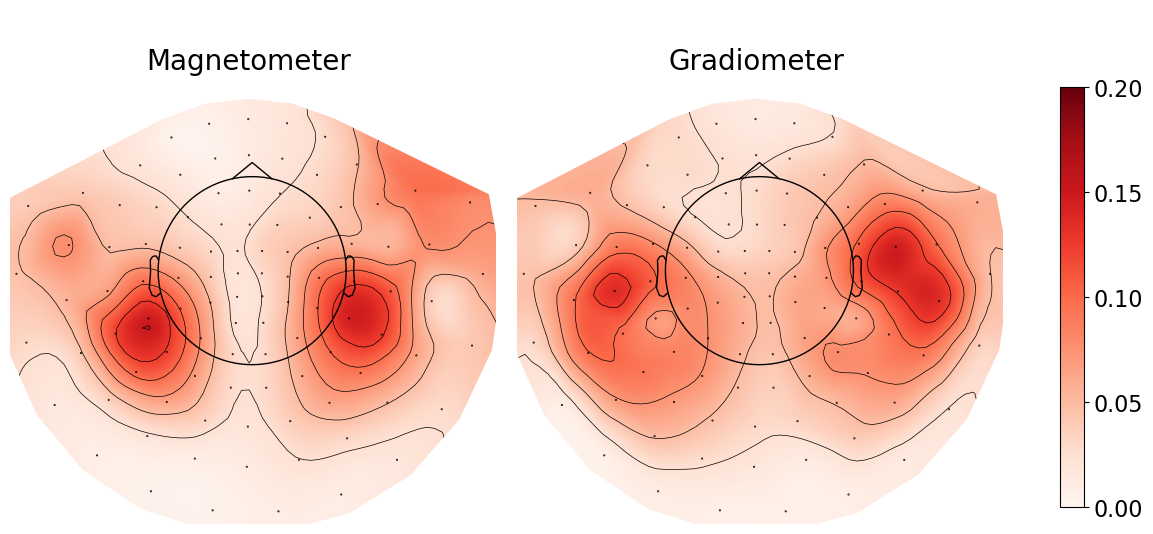

In [19]:
# plot correlation
mag_corr_chs = corr_meg[mag_idx]
grad_corr_chs = corr_meg[grad_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
h = mne.viz.plot_topomap(mag_corr_chs, mag_info, vlim=(0, 0.2), show=False, size=4, axes=axes[0], cmap="Reds")
h2 = mne.viz.plot_topomap(grad_corr_chs, grad_info, vlim=(0, 0.2), show=False, size=4, axes=axes[1], cmap="Reds")
for ax in axes:
    box = ax.get_position()
    ax.set_position([box.x0 - 0.08, box.y0, box.width * 1.15, box.height * 1.15])

# color bar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
plt.colorbar(h[0], cax=cbar_ax)
cbar_ax.set_yticks(np.arange(0, 0.21, 0.05))
cbar_ax.tick_params(labelsize=16)

# title
x0, y0 = 0, 0.21
axes[0].text(x0, y0, "Magnetometer", fontsize=20, ha="center", va="bottom", color="black")
axes[1].text(x0, y0, "Gradiometer", fontsize=20, ha="center", va="bottom", color="black")

if SAVEFIG:
    plt.savefig(f"figures/{MEG_SUBJECT}/my_meg_corr.png", dpi=300)
plt.show()